# Lab

In [1]:
!pip install gdown
!pip install pydotplus

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from IPython.display import Image
import pandas as pd
from functools import reduce
from xgboost import XGBClassifier

# Install the package gdown if you haven't already! It's only on pip.
# !pip install gdown
import gdown

import pydotplus
from tqdm import tqdm

# Plot inline
%matplotlib inline



# Decision Trees

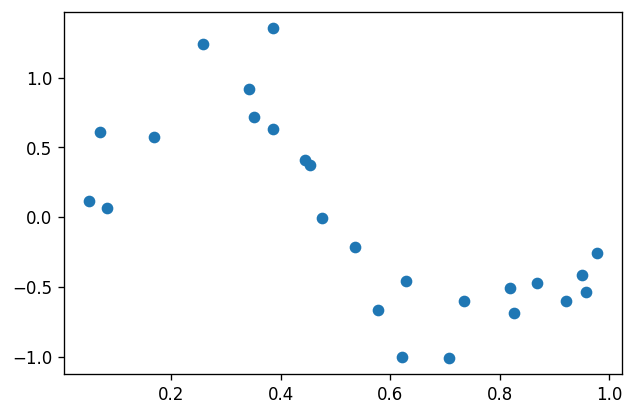

In [3]:
# Make some fake data
def make_regression_data(n=25):
    x = np.random.uniform(size = (n,1))
    e = np.random.normal(0, 0.3, size = x.shape)
    y = np.sin(2*np.pi*x) + e
    return (x,y.ravel())

x,y = make_regression_data()
fig, ax = plt.subplots(dpi = 120)
plt.scatter(x,y)
plt.show()

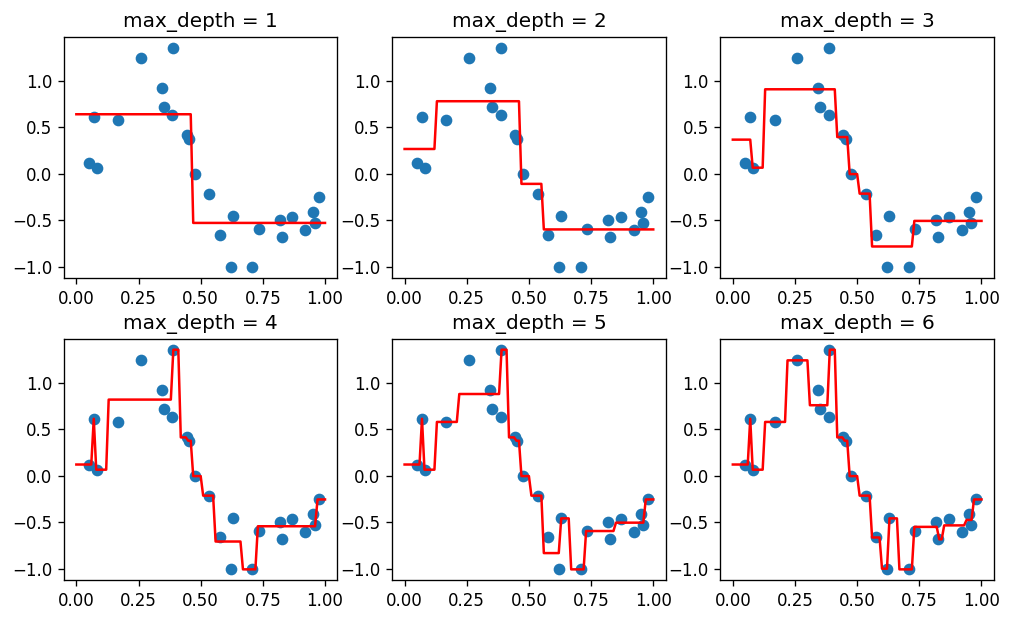

In [4]:
# Fit a regression tree to this data
# With varying max depth
# To see how this tree grows

depths = np.arange(1,7)
fig, ax = plt.subplots(dpi = 120, nrows = 2, ncols = 3, figsize = (10,6))
plt.subplots_adjust(hspace=0.25)
ax = ax.ravel() #flattens the ax variable

newx = np.linspace(0,1,101).reshape(-1,1)

for d,a in zip(depths, ax):
    reg = DecisionTreeRegressor(max_depth=d)
    reg.fit(x,y)
    
    ypred = reg.predict(newx)
    a.scatter(x,y)
    a.plot(newx, ypred, color = 'red')
    a.set_title(f'max_depth = {d}')

In [5]:
# Create DOT data
dot_data = export_graphviz(reg, out_file=None, rounded = True, max_depth=3, feature_names=['x'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

InvocationException: GraphViz's executables not found

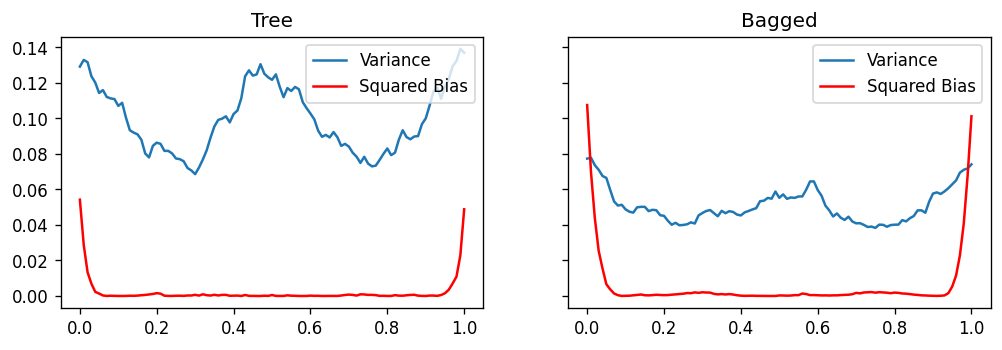

In [14]:
# Let's compare variance of predictions between a tree and a bagged estimator

# Create a tree model and a bagging from these trees
newx = np.linspace(0,1,101).reshape(-1,1)
tree = DecisionTreeRegressor(max_depth = 5)
bag1 = BaggingRegressor(DecisionTreeRegressor(max_depth = 5), 
                        n_estimators=100,
                       n_jobs = -1)

models = [tree, bag1,]
model_names = ['Tree', "Bagged"]

# Create two plots, one for the tree, one for the bagging
fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = len(models), figsize = (10,3), sharey = True)
ax = ax.ravel() #flattens the ax variable

# Generate 500 runs for each model and calculate bias and variance. This takes a while!
nsim = 500

for axis, model, name in zip(ax, models, model_names):
    
    #Store the predictions somewhere
    predictions = np.zeros((nsim, newx.shape[0]))
    
    for i in range(nsim):
        x,y = make_regression_data()
        model.fit(x,y)
        ypred = model.predict(newx)
        predictions[i] = ypred
        
    #Plot the variance
    axis.plot(newx, predictions.var(axis = 0), label = 'Variance')
    
    #Plot the bias
    bias = (predictions - np.sin(2*np.pi*newx.T)).mean(axis = 0)**2
    axis.plot(newx, bias, color = 'red', label = 'Squared Bias')
    axis.set_title(name)
    axis.legend()

## Random Forests

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large trees.)

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

Let's train one and check the options.

In [15]:
#Define the classifier
bankloan_rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=20190305, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    )

Now we are ready to train. I have created a credit risk dataset that can be used to predict the probability of not paying back a loan (a credit score). We will also split the data into a train and test set.

In [16]:
# Import the dataset from a shared Google Drive link I have already prepared.
url = 'https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs'
output = 'BankloanClean.pkl'
gdown.download(url, output, quiet = False)

# Read from the file we just got.
bankloan_data = pd.read_pickle('BankloanClean.pkl')

# Drop a categorical variable
bankloan_data.drop('Education', inplace = True, axis = 1)

Downloading...
From: https://drive.google.com/uc?id=1-RiFAF4zU27N9MnoSYUlNuqFhR3VcuWs
To: /Users/mayamon/Desktop/4414/4414 Assignment 8/BankloanClean.pkl
100%|██████████| 135k/135k [00:00<00:00, 2.84MB/s]


The data has the following variables:

- Customer: ID, or unique label, of the borrower (NOT predictive).
-    Age: Age of the borrower in years.
-    Employ: Years at current job.
-    Address: Years at current address.
-    Income: Income in ‘000s USD.
-    Leverage: Debt/Income Ratio.
-    CredDebt: Credit card standing debt.
-    OthDebt: Other debt in ‘000s USD.
-    MonthlyLoad: Monthly percentage from salary used to repay debts.
-    Default: 1 If default has occurred, 0 if not (Target variable).


In [17]:
bankloan_data.describe()

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad,Default
count,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000,1489.000000
mean,257649.480188,34.003358,6.799866,6.233714,56.898590,9.904835,1.801370,3.664231,0.366850,0.361988
std,139646.983244,12.982437,8.765093,5.987928,55.062182,6.649132,2.340326,4.665854,0.294387,0.480737
min,10012.000000,18.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98410.000000,24.000000,0.000000,2.000000,27.000000,4.800000,0.420000,1.100000,0.150000,0.000000
50%,316013.000000,31.000000,4.000000,5.000000,39.000000,8.500000,0.980000,2.200000,0.290000,0.000000
75%,370695.000000,41.000000,10.000000,9.000000,63.000000,13.500000,2.170000,4.500000,0.500000,1.000000
max,453777.000000,79.000000,63.000000,34.000000,533.000000,40.700000,19.050000,52.650000,2.150000,1.000000


Now we split the data into train and test.

In [19]:
bankloan_data.iloc[:, :-1]

,customer,Age,Employ,Address,Income,Leverage,Creddebt,OthDebt,MonthlyLoad
0,10012,28,7,2.0,44.0,17.7,2.99,4.80,0.58
1,10017,64,34,17.0,116.0,14.7,5.05,12.00,0.27
2,10030,40,20,12.0,61.0,4.8,1.04,1.89,0.13
3,10039,30,11,3.0,27.0,34.5,1.75,7.56,1.62
4,10069,25,2,2.0,30.0,22.4,0.76,5.96,0.97
...,...,...,...,...,...,...,...,...,...
1495,453471,34,8,4.0,83.0,11.0,1.85,7.28,0.24
1496,453578,37,10,8.0,43.0,3.6,0.81,0.74,0.12
1497,453686,25,0,3.0,16.0,3.2,0.29,0.22,0.23
1498,453698,34,10,8.0,41.0,14.5,1.19,4.75,0.50


In [ ]:
# Split into train and test, fixing seed.
bankloan_train_noWoE, bankloan_test_noWoE = train_test_split(bankloan_data.iloc[:, 1:], # Data 
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 20201107)   # Seed

Now we train!

In [ ]:
# Train the RF.
bankloan_rf.fit(bankloan_train_noWoE.iloc[:,:-1], 
               bankloan_train_noWoE['Default'])

We can see it used two jobs (two processors are available to me in this computer). It converges very quickly. Let's check how it did, this time we will print a nicer confusion matrix using seaborn, and will plot the ROC curve of the model. 

In [ ]:
# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

In [ ]:
# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Looks a bit unbalanced, but otherwise ok. It's harder to predict the  defaulters. Now let's see the ROC curve.

In [ ]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Now, let's print the variable importance. The importance is calculated by averaging the accuracy of trees when the variables is included the tree, and comparing it to when it's NOT included the tree.

In [ ]:
# Plot variable importance
importances = bankloan_rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

## XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

While scikit-learn does have its own implementation of XGB ([```sklearn.ensemble```](https://scikit-learn.org/stable/modules/ensemble.html)), there are a couple of very strong packages out there that implement the algorithm. ```xgboost``` and ```lightgbm``` are two of the best known ones. We will use [```xgboost```](https://xgboost.readthedocs.io/en/latest/python/) for this lab, available pretty much for every language out there.

The first step is to define a classifier that we will use.

In [ ]:
#Define the classifier.
XGB_Bankloan = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

This classifier can be used to tune the parameters of the model. We will use sklearn's ```GridSearchCV``` for this. It requires a dictionary of the parameters to look for. We will tune the number of trees (XGB overfits relatively easily, always tune this), the depth, and the learning rate.

In [ ]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3],
                 'learning_rate' : [0.001, 0.01, 0.1]
                  })

We will create a validation set for the sample.

In [ ]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = bankloan_train_noWoE.sample(frac = 0.3,               # The fraction to extract
                                       random_state = 20201107    # The seed.
                                       )

Now we can do a grid search over the parameter space. We will use the AUC (as this is a binary classification problem

In [ ]:
# Define grid search object.
GridXGB = GridSearchCV(XGB_Bankloan,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [ ]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train['Default'])

Now we can output the optimal parameters.

In [ ]:
# Show best params
GridXGB.best_params_

It is telling us to use 10% learning rate with a max_depth of 3 and 100 trees. As the max_depth parameter is at the limit, I would run again with a depth of four just to check one further the limit. I leave this as an exercise.

Now we can fit the final model!

In [ ]:
# Create XGB with best parameters.
XGB_Bankloan = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [ ]:
# Train over all training data.
XGB_Bankloan.fit(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE['Default'])

Now we can evaluate our model. First we calculate the variable importance.

In [ ]:
# Plot variable importance
importances = XGB_Bankloan.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

What do you see here? Does it make sense to you?

Let's finish by plotting the ROC curve. How does it compare to Random Forest? Why do you think this is?

In [ ]:
# Calculate probability
probTest = XGB_Bankloan.predict_proba(bankloan_test_noWoE.iloc[:, :-1])
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()